# Geospatial Analysis of Crash Cases in Philadelphia from 2010 - 2021

This data is aggregated by Police District.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas

In [5]:
# Spatial Plot
philly_map = geopandas.read_file("./Boundaries_District/Boundaries_District.shp")
#philly_map_police = geopandas.read_file("./PhillyPolice_Boundaries_District/PhillyPolice_Boundaries_District.shp")

# Crash Dataset
df = pd.read_csv("./APAC_2023_Datasets/Crashes/crash_info_general.csv")

/var/folders/pc/n3qxl__51zq83lxk2mhxs1x00000gn/T/ipykernel_22108/3871694329.py:6: DtypeWarning: Columns (97,98,99) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./APAC_2023_Datasets/Crashes/crash_info_general.csv")


In [6]:
# Create GeoSpatial DataFrame
crashes_coords = geopandas.GeoDataFrame(
    df,
    geometry=geopandas.points_from_xy(df['DEC_LONG'], df['DEC_LAT'])
)

In [7]:
# Map to district
crashes_coords['DISTRICT_'] = ''
for idx in range(philly_map.shape[0]):
    pip = crashes_coords.within(philly_map.loc[idx, 'geometry'])
    if pip.sum() > 0:
        crashes_coords.loc[pip, 'DISTRICT_'] = philly_map.loc[idx, 'DISTRICT_']
  

In [8]:
#Filter out invalid cases that do not fall within the districts
crashes_coords = crashes_coords[crashes_coords['DISTRICT_'] != '']

In [9]:
#Group by district and count
stats = crashes_coords.groupby(['DISTRICT_'])[['CRN']].count()

In [10]:
# Merge count into map
map_and_stats = philly_map.merge(stats, on='DISTRICT_')

(-75.2965363338824, -74.939522217298, 39.853475402027584, 40.15148900478962)

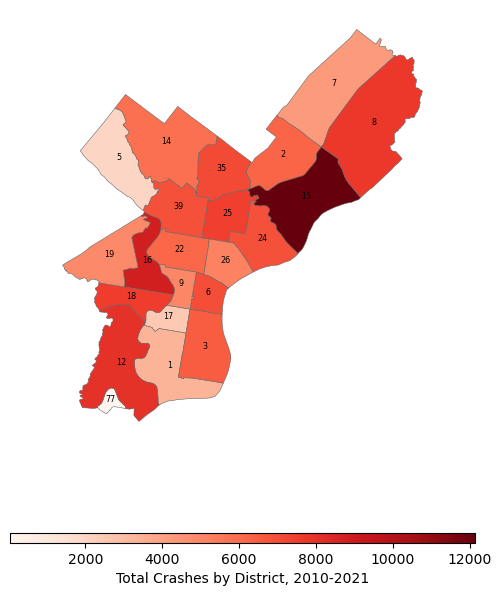

In [60]:
fig, ax = plt.subplots(1, figsize=(12,8))
plt.xticks(rotation=90)
map_and_stats.plot(
    column='CRN',
    cmap='Reds',
    linewidth=0.4,
    ax=ax,
    edgecolor='.4',
    legend=True,
    legend_kwds={
        'label': "Total Crashes by District, 2010-2021",
        'orientation': 'horizontal',
        'shrink': 0.5,
        'aspect': 50
    }
)
map_and_stats.apply(lambda x: ax.annotate(text=x['DIST_NUM'], xy=x.geometry.centroid.coords[0], ha='center', fontsize='xx-small'), axis=1)
ax.axis('off')

In [65]:
# Top 5 All time
map_and_stats.sort_values('CRN', ascending=False)[['DISTRICT_', 'CRN']][:5]

,DISTRICT_,CRN
13,15,12130
0,16,8840
20,12,8005
18,8,7706
2,18,7567


# Districts with the highest rate of increase in cases

Functions to generate rankings by percentage increase, and the tables themselves

In [85]:
def crashes_by_year(year: int):
    return crashes_coords[crashes_coords['CRASH_YEAR'] == year].groupby(['DISTRICT_'])['CRN'].count()

def highest_percent(time_in_years: int):
    if time_in_years > 10:
        return None
    LATEST_YEAR = 2021
    return ((crashes_by_year(LATEST_YEAR) - crashes_by_year(LATEST_YEAR - time_in_years)) / crashes_by_year(LATEST_YEAR) * 100).sort_values(ascending=False)

def highest_net(time_in_years: int):
    if time_in_years > 10:
        return None
    LATEST_YEAR = 2021
    return (crashes_by_year(LATEST_YEAR) - crashes_by_year(LATEST_YEAR - time_in_years)).sort_values(ascending=False)